# Sugar recovery model
Combines MF and multi-effect evaporation to generate a concentrated sugar stream 

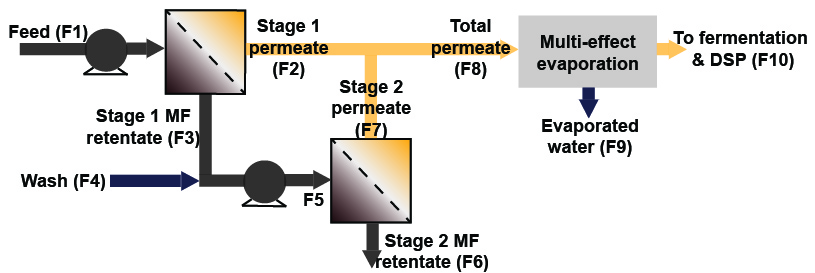

In [1]:
#Import Packages and Libraries
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.optimize as optimize
idx = pd.IndexSlice
from math import log, log10, exp, e, pow, sqrt
from scipy.optimize import root
import scipy.integrate as integrate
import scipy

#Adjusts window size for Jupyter notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\psaboe\AppData\Local\Temp\1\ipykernel_9820\3874531231.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#ASSUMPTIONS
MemCost = 2000 #USD per m2
MemLife = 5 #lifetime of membrane
OnStreamFac = 0.9 
MFenergyeff = 0.7 #Factor used to account for mechanical inefficiency and power factor 
Energycost = 0.078 #USD/kWh
#Disc speed of 1200 rpm (Figure 7 used to estimate filtration energy)

In [23]:
#Build dataframes for output data
colsS = ['SugRec','F1', 'F2', 'F3', 'F4', 'F5','F6','F7','F8'] #Stream Flowrates L/hr
dfS = pd.DataFrame(data=np.zeros((500, len(colsS))), columns = colsS)

colsC = ['SugRec','C1','C2','C3','C4','C5','C6','C7','C8'] #Sugar concentration g/L
dfC = pd.DataFrame(data=np.zeros((500, len(colsC))), columns = colsC)

colsP = ['SugRec','VR2', 'ISfeed', 'ISop', 'ISF5', 'ISop2', 'LMH', 'TotArea'] #IS concentration wt%
dfP = pd.DataFrame(data=np.zeros((500, len(colsP))), columns = colsP)

colsPT = ['F4','SugRec_6%','SugRec_9%', 'SugRec_11%','SugRec_15%'] #for plot
dfPT = pd.DataFrame(data=np.zeros((500, len(colsPT))), columns = colsPT)

colsPT2 = ['SugRec_6%','SugRec_9%', 'SugRec_11%','SugRec_15%','Area_6%','Area_9%','Area_11%','Area_15%'] #for plot 
dfPT2 = pd.DataFrame(data=np.zeros((500, len(colsPT2))), columns = colsPT2)

colsPT3 = ['SugRec_6%','SugRec_9%', 'SugRec_11%','SugRec_15%','EvapCost_6%','EvapCost_9%','EvapCost_11%','EvapCost_15%'] #for plot
dfPT3 = pd.DataFrame(data=np.zeros((500, len(colsPT3))), columns = colsPT3)

colsPT4 = ['SugRec_6%','SugRec_9%', 'SugRec_11%','SugRec_15%','MemMatCost_6%','MemMatCost_9%','MemMatCost_11%','MemMatCost_15%'] #fo
dfPT4 = pd.DataFrame(data=np.zeros((500, len(colsPT4))), columns = colsPT4)

colsPT5 = ['SugRec_6%','SugRec_9%', 'SugRec_11%','SugRec_15%','MFCost_6%','MFCost_9%','MFCost_11%','MFCost_15%'] #for plot
dfPT5 = pd.DataFrame(data=np.zeros((500, len(colsPT5))), columns = colsPT5)

colsPT6 = ['SugRec_6%','SugRec_9%', 'SugRec_11%','SugRec_15%','ProcessOPEX_6%','ProcessOPEX_9%','ProcessOPEX_11%','ProcessOPEX_15%'] #for plot
dfPT6 = pd.DataFrame(data=np.zeros((500, len(colsPT6))), columns = colsPT6)

#INPUTS
Feedflow = 10000  #L/hr (F1)                       
ISfeed = 3 #wt% - insoluble solids content in feed (F1)         
C1 = 100 #g/L sugar concentration in F1
C4 = 0 #g/L sugar in wash feed (F4)
F4 = 50000 #flow rate of wash feed
ISop = 6 #wt% - insoluble solids content in the retentate streams 

#Calculations
VR1 =  (ISop-ISfeed)/ISop #Volume recovery achieved in first stage based on desired IS content in retentate 

#Begin iteration across F4 (1-50,000 L/hr)
for WaterFlow in range(1,50001,100):
    F4 = WaterFlow
    
#Mass balance to determine stream flowrates

    F1 = Feedflow #L/hr feed flow rate
    F2 = F1*VR1 #Permeate flow rate set by volume recovery
    F3 = F1 - F2 #Mass balance over MF stage 1
    F5 = F3+F4 #Mixing of wash water with MF stage 1 retentate 

    ISop2 = ISop #Setting the desired insoluble content in the MF stage 2 retentate equal to the IS content in stage 1 retentate 

    C2 = C1 #Assumes no change in concentration of sugars across MF membrane
    C3 = C1 #Assumes no change in concentration of sugars across MF membrane

    ISF5 = (ISop*F3 + F4)/ (F3+F4) #Calculates the new IS concentration after dilution with wash water
    VR2 =  (ISop2-ISF5)/ISop2 #calculates the MF stage 2 recovery based on desired IS content in retenate 

    F7 = F5*VR2 #Permeate flow in Stage 2 set by volume recovery
    F8 = F2 + F7 #Combining the permeate flows
    F6 = F5 - F7 #Mass balance over MF stage 2
    
    # Estimating the sugar lost due to entrainment during washing 
    CakeF3 = ISop/100*F3 #Mass flow of insoluble solids
    LCF3 = CakeF3 *(1-ISop/100) #estimated total liquid entrained with insoluble solids
    W = F4 / LCF3 #wash ratio (wash water / liquid flow of cake) REF: Sievers, David A., Ling Tao, and Daniel J. Schell., Bioresource technology 167 (2014): 291-296.
    CakeC = C3 * 1.5 * exp(-1.21 * W) #Concentration of sugars in entrained fraction REF: Sievers, David A., Ling Tao, and Daniel J. Schell., Bioresource technology 167 (2014): 291-296.
    SF5 = F3*C3/1000-CakeF3*CakeC/1000 #Sugar flow rate in F5 after dilution accounting for entrainment 
    ISF5 = F3*C3/1000 #Ideal sugar flow rate in F5 after dilution without accounting for entrainment
    RF5 = SF5/ISF5 #Recovery of sugars during washing
    C5 = RF5 * F3 * C3 / F5 #New C5 concentration of sugars accounting for entrainment 
    
    C6 = C5 #Assumes no change in concentration of sugars across MF membrane
    C7 = C5 #Assumes no change in concentration of sugars across MF membrane
    C8 = (F2*C2 + F7*C7)/(F2+F7) #calculates concentration of sugars after mixing the two permeate streams 

    SugRec = F8*C8 / (F1*C1) #Total sugar recovery from two-stage MF process
    
    #OPEX estimate
    LMH = -0.425*(ISop)**2 - 0.44*ISop +132.33 #Estimates flux of MF units based on IS content in retentate (Figure 3 of main text)
    
    Area1 = F2/LMH #Area needed for MF stage 1
    Area2 = F7/LMH #Area needed for MF stage 2
    TotArea = Area1 + Area2 #Total membrane needed for stage 1+2
    
    MemMatCost = MemCost / MemLife / OnStreamFac / 365 / 24 / (F8*C8/1000) * TotArea #Membrane material replacement cost on a kg sugar basis (units of $/kg sugar)
    
    MFenergyW = 0.1317*exp(0.1819*ISop) #Watts of energy associated with disc filtration (Figure 7 of main text at 1200 rpm)
    MFenergykWkg = MFenergyW/.034 / 1000 / LMH / C8 *1000 *MFenergyeff #conversion to kW/kg of sugar
    MFenergyMJkg = MFenergyW/.034 / 1000 / LMH / C8 *1000 *MFenergyeff*3.6 #conversion to MJ/kg of sugar
    MFenergycost = MFenergykWkg*Energycost #USD per kg sugar associated with filtration electrical energy consumption
    MFcost = MFenergycost + MemMatCost #Total MF operating cost including material replacement costs and energy cost
    MFcostm3 = MFcost*C8 #MF cost on a m3 basis
    MFenergykWm3 = MFenergyW/.034 / 1000 / LMH / C8 #MF energy with units of kW/m3
    
    EvapCost = 0.0003 * (C8/10/100)**-1.493 #Utility cost in USD/kg glucose
    
    ProcessOPEX = EvapCost + MFcost #Estimated OPEX 
    
    #Data frames 
    dfS.loc[idx[WaterFlow-1],idx['SugRec']] = SugRec
    dfS.loc[idx[WaterFlow-1],idx['F1']] = F1
    dfS.loc[idx[WaterFlow-1],idx['F2']] = F2
    dfS.loc[idx[WaterFlow-1],idx['F3']] = F3
    dfS.loc[idx[WaterFlow-1],idx['F4']] = F4
    dfS.loc[idx[WaterFlow-1],idx['F5']] = F5
    dfS.loc[idx[WaterFlow-1],idx['F6']] = F6
    dfS.loc[idx[WaterFlow-1],idx['F7']] = F7
    dfS.loc[idx[WaterFlow-1],idx['F8']] = F8
    
    dfC.loc[idx[WaterFlow-1],idx['SugRec']] = SugRec
    dfC.loc[idx[WaterFlow-1],idx['C1']] = C1
    dfC.loc[idx[WaterFlow-1],idx['C2']] = C2
    dfC.loc[idx[WaterFlow-1],idx['C3']] = C3
    dfC.loc[idx[WaterFlow-1],idx['C4']] = C4
    dfC.loc[idx[WaterFlow-1],idx['C5']] = C5
    dfC.loc[idx[WaterFlow-1],idx['C6']] = C6
    dfC.loc[idx[WaterFlow-1],idx['C7']] = C7
    dfC.loc[idx[WaterFlow-1],idx['C8']] = C8
    
    dfP.loc[idx[WaterFlow-1],idx['SugRec']] = SugRec
    dfP.loc[idx[WaterFlow-1],idx['VR2']] = VR2
    dfP.loc[idx[WaterFlow-1],idx['ISfeed']] = ISfeed
    dfP.loc[idx[WaterFlow-1],idx['ISop']] = ISop
    dfP.loc[idx[WaterFlow-1],idx['ISF5']] = ISF5
    dfP.loc[idx[WaterFlow-1],idx['ISop2']] = ISop2
    dfP.loc[idx[WaterFlow-1],idx['LMH']] = LMH
    dfP.loc[idx[WaterFlow-1],idx['TotArea']] = TotArea
    
    dfPT.loc[idx[WaterFlow-1],idx['F4']] = F4
    dfPT.loc[idx[WaterFlow-1],idx['SugRec_6%']] = SugRec
    
    dfPT2.loc[idx[WaterFlow-1],idx['SugRec_6%']] = SugRec
    dfPT2.loc[idx[WaterFlow-1],idx['Area_6%']] = TotArea
    
    dfPT3.loc[idx[WaterFlow-1],idx['SugRec_6%']] = SugRec
    dfPT3.loc[idx[WaterFlow-1],idx['EvapCost_6%']] = EvapCost
    
    dfPT4.loc[idx[WaterFlow-1],idx['SugRec_6%']] = SugRec
    dfPT4.loc[idx[WaterFlow-1],idx['MemMatCost_6%']] = MemMatCost
    
    dfPT5.loc[idx[WaterFlow-1],idx['SugRec_6%']] = SugRec
    dfPT5.loc[idx[WaterFlow-1],idx['MFCost_6%']] = MFcost
    
    dfPT6.loc[idx[WaterFlow-1],idx['SugRec_6%']] = SugRec
    dfPT6.loc[idx[WaterFlow-1],idx['ProcessOPEX_6%']] = ProcessOPEX
    

    

In [24]:
dfPT.to_excel("2-stage-model_outputs.xlsx")
dfPT2.to_excel("2-stage-model_outputs_area.xlsx")
dfPT3.to_excel("2-stage-model_outputs_EvapCost.xlsx")
dfPT4.to_excel("2-stage-model_outputs_MemMatCost.xlsx")
dfPT5.to_excel("2-stage-model_outputs_MFCost.xlsx")
dfPT6.to_excel("2-stage-model_outputs_ProcessOPEX.xlsx")

#df=pd.read_excel(r'C:\Users\
#df2=pd.read_excel(r'C:\Users\
#df3=pd.read_excel(r'C:\Users\
#df4=pd.read_excel(r'C:\Users\
#df5=pd.read_excel(r'C:\Users\ 
#df6=pd.read_excel(r'C:\Users\

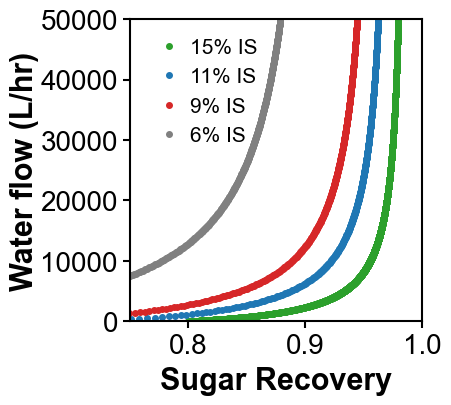

In [10]:
fig, (fig1) = plt.subplots(1,1,sharey=False,sharex=False,figsize=(5,5))

fig.tight_layout(pad=6.0)

plt.rc('font',family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

fig1.set_xlabel('Sugar Recovery',fontsize=22,fontname="Arial",weight='bold',labelpad=5)
fig1.set_ylabel('Water flow (L/hr)',fontsize=22,fontname="Arial",weight='bold',labelpad=1)

fig1.plot(df.iloc[:,5], df.iloc[:,1],'o',markerfacecolor='tab:green',markeredgecolor='tab:green', markersize=4, label='15%')
fig1.plot(df.iloc[:,4], df.iloc[:,1],'o',markerfacecolor='tab:blue',markeredgecolor='tab:blue', markersize=4, label='11% IS')
fig1.plot(df.iloc[:,3], df.iloc[:,1],'o',markerfacecolor='tab:red',markeredgecolor='tab:red', markersize=4, label='9% IS')
fig1.plot(df.iloc[:,2], df.iloc[:,1],'o',markerfacecolor='gray',markeredgecolor='gray', markersize=4, label='6% IS')


for tick in fig1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in fig1.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in fig1.get_xticklabels():
    tick.set_fontsize(20)
for tick in fig1.get_yticklabels():
    tick.set_fontsize(20)
    
plt.xlim([.75, 1])
plt.ylim([0, 50000])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

fig1.legend(['15% IS','11% IS','9% IS', '6% IS'],loc='upper left',frameon=False,labelspacing = .5, fontsize=15,handletextpad=0)

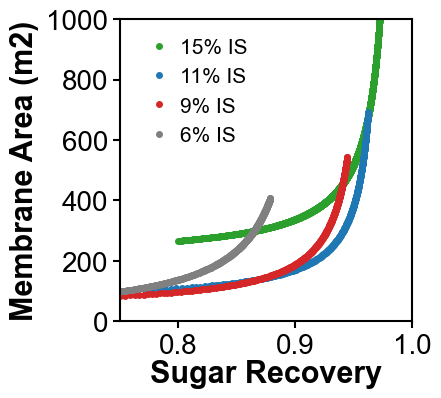

In [12]:
fig, (fig1) = plt.subplots(1,1,sharey=False,sharex=False,figsize=(5,5))

fig.tight_layout(pad=6.0)

plt.rc('font',family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

fig1.set_xlabel('Sugar Recovery',fontsize=22,fontname="Arial",weight='bold',labelpad=0)
fig1.set_ylabel('Membrane Area (m2)',fontsize=22,fontname="Arial",weight='bold',labelpad=5)


fig1.plot(df2.iloc[:,4], df2.iloc[:,8],'o',markerfacecolor='tab:green',markeredgecolor='tab:green', markersize=4, label='15%')
fig1.plot(df2.iloc[:,3], df2.iloc[:,7],'o',markerfacecolor='tab:blue',markeredgecolor='tab:blue', markersize=4, label='11% IS')
fig1.plot(df2.iloc[:,2], df2.iloc[:,6],'o',markerfacecolor='tab:red',markeredgecolor='tab:red', markersize=4, label='9% IS')
fig1.plot(df2.iloc[:,1], df2.iloc[:,5],'o',markerfacecolor='gray',markeredgecolor='gray', markersize=4, label='6% IS')


for tick in fig1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in fig1.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in fig1.get_xticklabels():
    tick.set_fontsize(20)
for tick in fig1.get_yticklabels():
    tick.set_fontsize(20)
    
plt.xlim([.75, 1])
plt.ylim([0, 1000])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

fig1.legend(['15% IS','11% IS','9% IS', '6% IS'],loc='upper left',frameon=False,labelspacing = 0.5, fontsize=15,handletextpad=0)

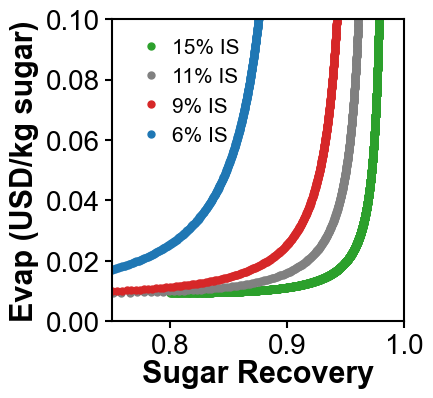

In [31]:
fig, (fig1) = plt.subplots(1,1,sharey=False,sharex=False,figsize=(5,5))

fig.tight_layout(pad=6.0)

plt.rc('font',family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

fig1.set_xlabel('Sugar Recovery',fontsize=22,fontname="Arial",weight='bold',labelpad=0)
fig1.set_ylabel('Evap (USD/kg sugar)',fontsize=22,fontname="Arial",weight='bold',labelpad=5)

fig1.plot(df3.iloc[:,4], df3.iloc[:,8],'o',markerfacecolor='tab:green',markeredgecolor='tab:green', markersize=5, label='15%')
fig1.plot(df3.iloc[:,3], df3.iloc[:,7],'o',markerfacecolor='gray',markeredgecolor='gray', markersize=5, label='11% IS')
fig1.plot(df3.iloc[:,2], df3.iloc[:,6],'o',markerfacecolor='tab:red',markeredgecolor='tab:red', markersize=5, label='9% IS')
fig1.plot(df3.iloc[:,1], df3.iloc[:,5],'o',markerfacecolor='tab:blue',markeredgecolor='tab:blue', markersize=5, label='6% IS')


for tick in fig1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in fig1.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in fig1.get_xticklabels():
    tick.set_fontsize(20)
for tick in fig1.get_yticklabels():
    tick.set_fontsize(20)
    
plt.xlim([.75, 1])
plt.ylim([0, .1])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

fig1.legend(['15% IS','11% IS','9% IS', '6% IS'],loc='upper left',frameon=False,labelspacing = 0.5, fontsize=15,handletextpad=0)

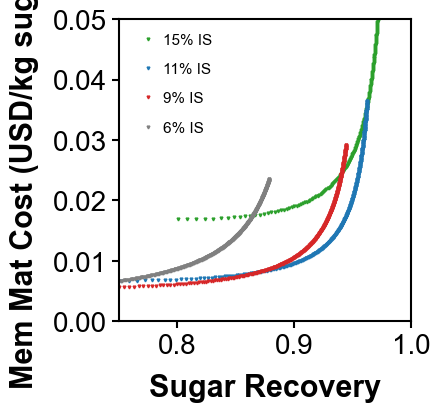

In [8]:
fig, (fig1) = plt.subplots(1,1,sharey=False,sharex=False,figsize=(5,5))

fig.tight_layout(pad=6.0)

plt.rc('font',family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

fig1.set_xlabel('Sugar Recovery',fontsize=22,fontname="Arial",weight='bold',labelpad=10)
fig1.set_ylabel('Mem Mat Cost (USD/kg sugar)',fontsize=22,fontname="Arial",weight='bold',labelpad=10)

fig1.plot(df4.iloc[:,4], df4.iloc[:,8],'v',markerfacecolor='tab:green',markeredgecolor='tab:green', markersize=2, label='15%')
fig1.plot(df4.iloc[:,3], df4.iloc[:,7],'v',markerfacecolor='tab:blue',markeredgecolor='tab:blue', markersize=2, label='11% IS')
fig1.plot(df4.iloc[:,2], df4.iloc[:,6],'v',markerfacecolor='tab:red',markeredgecolor='tab:red', markersize=2, label='9% IS')
fig1.plot(df4.iloc[:,1], df4.iloc[:,5],'v',markerfacecolor='gray',markeredgecolor='gray', markersize=2, label='6% IS')


for tick in fig1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in fig1.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in fig1.get_xticklabels():
    tick.set_fontsize(20)
for tick in fig1.get_yticklabels():
    tick.set_fontsize(20)
    
plt.xlim([.75, 1])
plt.ylim([0, .05])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

fig1.legend(['15% IS','11% IS','9% IS', '6% IS'],loc='upper left',frameon=False,labelspacing = 1, fontsize=11,handletextpad=0)

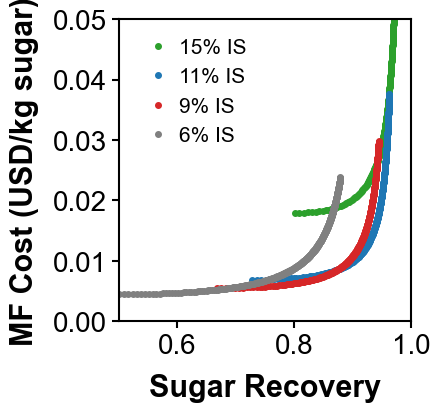

In [9]:
fig, (fig1) = plt.subplots(1,1,sharey=False,sharex=False,figsize=(5,5))

fig.tight_layout(pad=6.0)

plt.rc('font',family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

fig1.set_xlabel('Sugar Recovery',fontsize=22,fontname="Arial",weight='bold',labelpad=10)
fig1.set_ylabel('MF Cost (USD/kg sugar)',fontsize=22,fontname="Arial",weight='bold',labelpad=10)

fig1.plot(df5.iloc[:,4], df5.iloc[:,8],'o',markerfacecolor='tab:green',markeredgecolor='tab:green', markersize=4, label='15%')
fig1.plot(df5.iloc[:,3], df5.iloc[:,7],'o',markerfacecolor='tab:blue',markeredgecolor='tab:blue', markersize=4, label='11% IS')
fig1.plot(df5.iloc[:,2], df5.iloc[:,6],'o',markerfacecolor='tab:red',markeredgecolor='tab:red', markersize=4, label='9% IS')
fig1.plot(df5.iloc[:,1], df5.iloc[:,5],'o',markerfacecolor='gray',markeredgecolor='gray', markersize=4, label='6% IS')


for tick in fig1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in fig1.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in fig1.get_xticklabels():
    tick.set_fontsize(20)
for tick in fig1.get_yticklabels():
    tick.set_fontsize(20)
    
plt.xlim([.5, 1])
plt.ylim([0, 0.05])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

fig1.legend(['15% IS','11% IS','9% IS', '6% IS'],loc='upper left',frameon=False,labelspacing = 0.5, fontsize=15,handletextpad=0)

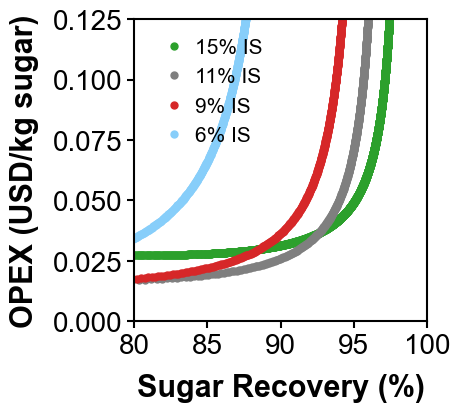

In [37]:
fig, (fig1) = plt.subplots(1,1,sharey=False,sharex=False,figsize=(5,5))

fig.tight_layout(pad=6.0)

plt.rc('font',family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

fig1.set_xlabel('Sugar Recovery (%)',fontsize=22,fontname="Arial",weight='bold',labelpad=10)
fig1.set_ylabel('OPEX (USD/kg sugar)',fontsize=22,fontname="Arial",weight='bold',labelpad=10)

fig1.plot(df6.iloc[:,4]*100, df6.iloc[:,8],'o',markerfacecolor='tab:green',markeredgecolor='tab:green', markersize=5, label='15%')
fig1.plot(df6.iloc[:,3]*100, df6.iloc[:,7],'o',markerfacecolor='tab:gray',markeredgecolor='tab:gray', markersize=5, label='11% IS')
fig1.plot(df6.iloc[:,2]*100, df6.iloc[:,6],'o',markerfacecolor='tab:red',markeredgecolor='tab:red', markersize=5, label='9% IS')
fig1.plot(df6.iloc[:,1]*100, df6.iloc[:,5],'o',markerfacecolor='lightskyblue',markeredgecolor='lightskyblue', markersize=5, label='6% IS')


for tick in fig1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in fig1.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in fig1.get_xticklabels():
    tick.set_fontsize(20)
for tick in fig1.get_yticklabels():
    tick.set_fontsize(20)
    
plt.xlim([80, 100])
plt.ylim([0, .125])

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

fig1.legend(['15% IS','11% IS','9% IS', '6% IS'],loc='upper left',frameon=False,labelspacing = 0.5, fontsize=15,handletextpad=0)
